In [102]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset Exploration and Modification

In [104]:
# read in dinosaur.csv and modify input so that the list only contains lowercase dinosaur names with no whitespace
dinosaur_csv = pd.read_csv('dinosaur.csv')
dinosaurs = dinosaur_csv['Name'].tolist()
dinosaurs = [d.lower().strip() for d in dinosaurs]
random.shuffle(dinosaurs)
dinosaurs[:5]

['angaturama',
 'crichtonsaurus',
 'turanoceratops',
 'philovenator',
 'sinocoelurus']

In [105]:
len(dinosaurs) # number of dinosaur names

1152

In [106]:
chars = sorted(list(set(''.join(dinosaurs)))) # sort letter alphabetically with no repeating letters
stoi = {s:i+1 for i, s in enumerate(chars)} # create a mapping of chars to integers
stoi['.'] = 0 # add special start and end character

itos = {i:s for s,i in stoi.items()} # create a integer to char mapping

print("stoi: ",  stoi)
print("itos: ", itos)

stoi:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Multi-Layer Perceptron (MLP) Implementation

In [107]:
# create the dataset

block_size = 3 # characters needed to predict one
X, Y = [], [] # initialize input and label arrays

for d in dinosaurs:
    context = [0] * block_size # create context 'window'
    for char in d + '.':
        idx = stoi[char] # get current character index
        
        X.append(context) # add current context to inputs
        Y.append(idx) # add current index to label
        context = context[1:] + [idx] # slide context 'window'
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [108]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([14856, 3]), torch.int64, torch.Size([14856]), torch.int64)

In [150]:
g = torch.Generator().manual_seed(42) # create a generator object for reproducability

C = torch.randn((27,2), generator=g) # create a lookup table

W1 = torch.randn((6,100), generator=g) # first weights matrix (6 inputs, 100 outputs)
b1 = torch.randn(100, generator=g) # first bias

W2 = torch.randn((100,27), generator=g) # second weights matrix (100 inputs, 27 outputs)
b2 = torch.randn(27, generator=g) # second bias

params = [C,W1,b1,W2,b2]
print("# of parameters: ", sum(p.nelement() for p in params))

# of parameters:  3481


In [151]:
for p in params:
    p.requires_grad = True

In [152]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [163]:
lri = []
lossi = []
for i in range(10000):
    
    # create mini-batch
    idx = torch.randint(0, X.shape[0], (35,))
    
    # forward pass
    emb = C[X[idx]] # create embeddings of shape (35, 3, 2)

    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # output of first layer of shape (35, 100)
    logits = h @ W2 + b2 # output of second layer of shape (35, 27)

    loss = F.cross_entropy(logits, Y[idx]) # use cross entropy as loss function
    #print(loss.item())    

    # backward pass
    for p in params:
        p.grad = None

    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 10**-1.5
    for p in params:
        p.data +=  -lr * p.grad
        
    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

#print(loss.item())

In [164]:
# forward pass
emb = C[X] # create embeddings on entire set

h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # output of first layer of shape (35, 100)
logits = h @ W2 + b2 # output of second layer of shape (35, 27)

loss = F.cross_entropy(logits, Y) # use cross entropy as loss function
loss.item()

1.5440661907196045

# Dataset Splitting and Model Training

In [264]:
# dataset splitting into train(80%), dev/validation(10%), test(10%)
# train is used to train parameters
# dev/validation is used to train hyperparameters
# test is used to evaluate the model
train, dev, test = torch.utils.data.random_split(dinosaurs, [0.8, 0.1, 0.1], generator=g)

# function to create inputs and outputs from dataset
def build_dataset(dataset):
    X, Y = [], []
    for d in dataset:
        context = [0] * block_size # create context 'window'
        for char in d + '.':
            idx = stoi[char] # get current character index

            X.append(context) # add current context to inputs
            Y.append(idx) # add current index to label
            context = context[1:] + [idx] # slide context 'window'
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y
    

# defining training inputs and labels
Xtr, Ytr = build_dataset(train)
print("TRAIN: ", Xtr.shape, Ytr.shape)

# defining validation inputs and labels
Xdev, Ydev = build_dataset(dev)
print("DEV: ", Xdev.shape, Ydev.shape)

# defining test inputs and labels
Xte, Yte = build_dataset(test)
print("TEST: ", Xte.shape, Yte.shape)

TRAIN:  torch.Size([11861, 3]) torch.Size([11861])
DEV:  torch.Size([1487, 3]) torch.Size([1487])
TEST:  torch.Size([1508, 3]) torch.Size([1508])


In [265]:
g = torch.Generator().manual_seed(42) # create a generator object for reproducability

C = torch.randn((27,10), generator=g) # create a lookup table

W1 = torch.randn((30,200), generator=g) # first weights matrix (30 inputs, 200 outputs)
b1 = torch.randn(200, generator=g) # first bias

W2 = torch.randn((200,27), generator=g) # second weights matrix (200 inputs, 27 outputs)
b2 = torch.randn(27, generator=g) # second bias

params = [C,W1,b1,W2,b2]
print("# of parameters: ", sum(p.nelement() for p in params))

# of parameters:  11897


In [266]:
for p in params:
    p.requires_grad = True

In [267]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [268]:
lri = []
lossi = []
stepi = []

In [270]:
for i in range(200000):
    
    # create mini-batch
    idx = torch.randint(0, Xtr.shape[0], (35,))
    
    # forward pass
    emb = C[Xtr[idx]] # create embeddings of shape (35, 3, 2)

    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # output of first layer of shape (35, 200)
    logits = h @ W2 + b2 # output of second layer of shape (35, 27)

    loss = F.cross_entropy(logits, Ytr[idx]) # use cross entropy as loss function
    #print(loss.item())    

    # backward pass
    for p in params:
        p.grad = None

    loss.backward()
    
    # update
    # lr = lrs[i]
    lr=10**-0.5 if i < 100000 else 10**-1.5
    for p in params:
        p.data +=  -lr * p.grad
        
    # track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

#print(loss.item())

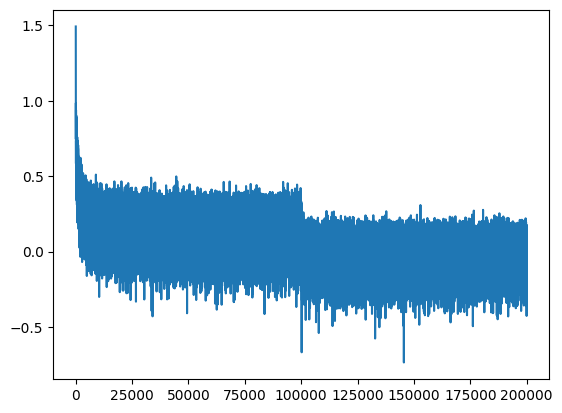

In [271]:
plt.plot(stepi, lossi)

In [272]:
# forward pass
emb = C[Xtr] # create embeddings on entire set

h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # output of first layer of shape (35, 200)
logits = h @ W2 + b2 # output of second layer of shape (35, 27)

loss = F.cross_entropy(logits, Ytr) # use cross entropy as loss function
loss.item()

0.9647422432899475

In [273]:
# forward pass
emb = C[Xdev] # create embeddings on entire set

h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # output of first layer of shape (35, 200)
logits = h @ W2 + b2 # output of second layer of shape (35, 27)

loss = F.cross_entropy(logits, Ydev) # use cross entropy as loss function
loss.item()

3.0291054248809814

In [275]:
# sample from model
for _ in range(5):
    out = [] # output array
    context = [0] * block_size # context 'window'
    
    while True:
        emb = C[torch.tensor([context])] # get embeddings from context and lookup table
        
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) # first layer: tanh
        logits = h @ W2 + b2 # second layer: linear
        probs = F.softmax(logits, dim=1) # softmax to get probabilites
        
        idx = torch.multinomial(probs, num_samples=1, generator=g).item() # get next predicted letter
        context = context[1:] + [idx] # slide the context 'window'
        out.append(idx) # append the new letter to the output
        
        # if the character is '.' then end the word
        if idx == 0:
            break
    
    print(''.join(itos[i] for i in out))

padilokesaurus.
cratops.
gentinisaurus.
chuangosaurus.
gracoxa.


### Compared to the Bigram and Trigram models, it is clear that the MLP (even with only two layers) creates much better dinosaur names!

# Tuning the Model

In [289]:
g = torch.Generator().manual_seed(42) # create a generator object for reproducability

C = torch.randn((27,9), generator=g) # create a lookup table

W1 = torch.randn((27,200), generator=g) # first weights matrix (27 inputs, 200 outputs)
b1 = torch.randn(200, generator=g) # first bias

W2 = torch.randn((200,27), generator=g) # second weights matrix (200 inputs, 27 outputs)
b2 = torch.randn(27, generator=g) # second bias

params = [C,W1,b1,W2,b2]
print("# of parameters: ", sum(p.nelement() for p in params))

# of parameters:  11270


In [290]:
for p in params:
    p.requires_grad = True

In [291]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [292]:
lri = []
lossi = []
stepi = []

In [293]:
for i in range(50000):
    
    # create mini-batch
    idx = torch.randint(0, Xtr.shape[0], (50,))
    
    # forward pass
    emb = C[Xtr[idx]] # create embeddings of shape (50, 3, 2)

    h = torch.tanh(emb.view(-1, 27) @ W1 + b1) # output of first layer of shape (50, 200)
    logits = h @ W2 + b2 # output of second layer of shape (50, 27)

    loss = F.cross_entropy(logits, Ytr[idx]) # use cross entropy as loss function
    #print(loss.item())    

    # backward pass
    for p in params:
        p.grad = None

    loss.backward()
    
    # update
    # lr = lrs[i]
    lr=10**-0.5 if i < 25000 else 10**-1.5
    for p in params:
        p.data +=  -lr * p.grad
        
    # track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

#print(loss.item())

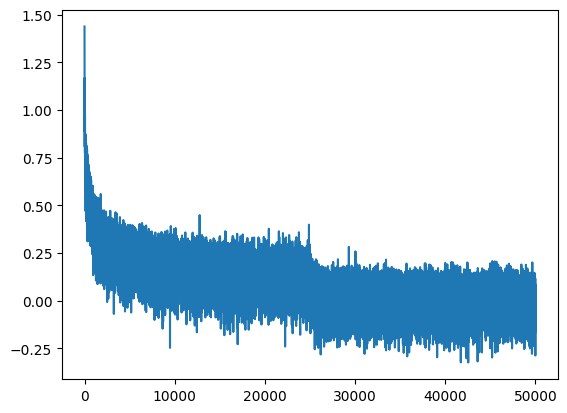

In [294]:
plt.plot(stepi, lossi)

In [295]:
# forward pass
emb = C[Xtr] # create embeddings on entire set

h = torch.tanh(emb.view(-1, 27) @ W1 + b1) # output of first layer of shape (50, 100)
logits = h @ W2 + b2 # output of second layer of shape (50, 27)

loss = F.cross_entropy(logits, Ytr) # use cross entropy as loss function
loss.item()

1.0062944889068604

In [296]:
# forward pass
emb = C[Xdev] # create embeddings on entire set

h = torch.tanh(emb.view(-1, 27) @ W1 + b1) # output of first layer of shape (50, 100)
logits = h @ W2 + b2 # output of second layer of shape (50, 27)

loss = F.cross_entropy(logits, Ydev) # use cross entropy as loss function
loss.item()

2.459195137023926

In [297]:
# sample from model
for _ in range(5):
    out = [] # output array
    context = [0] * block_size # context 'window'
    
    while True:
        emb = C[torch.tensor([context])] # get embeddings from context and lookup table
        
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) # first layer: tanh
        logits = h @ W2 + b2 # second layer: linear
        probs = F.softmax(logits, dim=1) # softmax to get probabilites
        
        idx = torch.multinomial(probs, num_samples=1, generator=g).item() # get next predicted letter
        context = context[1:] + [idx] # slide the context 'window'
        out.append(idx) # append the new letter to the output
        
        # if the character is '.' then end the word
        if idx == 0:
            break
    
    print(''.join(itos[i] for i in out))

cryongasaurus.
alamosaurus.
ruelanosaurus.
pelta.
dinoplioceratops.


### After further tuning, the dev loss dropped down to a 2.46 from 3.03, and the resulting dinosaur names are even better! 